In [1]:
pip install xarray

  Using cached xarray-2025.6.1-py3-none-any.whl.metadata (12 kB)
Using cached xarray-2025.6.1-py3-none-any.whl (1.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install toolz

  Using cached toolz-1.0.0-py3-none-any.whl.metadata (5.1 kB)
Using cached toolz-1.0.0-py3-none-any.whl (56 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install netcdf4

  Using cached cftime-1.6.4.post1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.7 kB)
Using cached cftime-1.6.4.post1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.4 MB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install cartopy

  Using cached Cartopy-0.24.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.9 kB)
  Using cached pyshp-2.3.1-py2.py3-none-any.whl.metadata (55 kB)
Using cached Cartopy-0.24.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)
Using cached pyshp-2.3.1-py2.py3-none-any.whl (46 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install h5netcdf 

  Using cached h5netcdf-1.6.1-py3-none-any.whl.metadata (13 kB)
  Using cached h5py-3.14.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.7 kB)
Using cached h5netcdf-1.6.1-py3-none-any.whl (49 kB)
Using cached h5py-3.14.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install cftime

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install cfgrib

  Using cached cfgrib-0.9.15.0-py3-none-any.whl.metadata (55 kB)
  Using cached eccodes-2.41.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (14 kB)
  Using cached findlibs-0.1.1-py3-none-any.whl.metadata (3.6 kB)
Using cached cfgrib-0.9.15.0-py3-none-any.whl (48 kB)
Using cached eccodes-2.41.0-cp311-cp311-manylinux_2_28_x86_64.whl (7.4 MB)
Using cached findlibs-0.1.1-py3-none-any.whl (10 kB)
Note: you may need to restart the kernel to use updated packages.


In [8]:
import xarray as xr
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

### **<font color="Purple"> Datos de ERA5 </font>**

### **<font color="olive"> Temperatura</font>**

In [68]:
filet2m_era5 = 'datasetsok/t2mC_1979_2024.nc'

In [264]:
t2m_ds=xr.open_dataset(filet2m_era5)
t2m=t2m_ds['t2m']
t2m['time'] = t2m.time.dt.floor("D")

In [161]:
t2m_inviernos = t2m.sel(time=t2m['time.month'].isin([12, 1, 2]))
t2m_inviernos['time'] = t2m_inviernos.time.dt.floor("D")

##### **<font color="olive"> Geopotencial </font>**

##### **<font color="olive"> Concat de índice >1 y valores de gph </font>**

In [189]:
# esta es la base que tiene solo las fechas cuando el índice > 1
# es también las anomalías del ciclo anual de gph

In [280]:
idxp_gph_file = 'datasetsok/gph_idx_std+.nc'

In [281]:
idxp_gph_ds = xr.open_dataset(idxp_gph_file)
idxp_gph = idxp_gph_ds['z']
idxp_gph = idxp_gph.sel(pressure_level=500)
idxp_gph['time'] = idxp_gph.time.dt.floor("D")

##### **<font color="olive"> Concat de índice <-1 y valores de gph </font>**

In [192]:
idxn_gph_file = 'datasetsok/gph_idx_std-.nc'

In [193]:
idxn_gph_ds = xr.open_dataset(idxn_gph_file)
idxn_gph = idxn_gph_ds['z']
idxn_gph = idxn_gph.sel(pressure_level=500)

In [194]:
idxn_gph_vals = idxn_gph.mean(dim='time')
idxn_gph_seasons = idxn_gph.groupby(idxn_gph.time.dt.season).mean(dim='time') #DJF
idxn_gph_djf = idxn_gph_seasons[0]

##### **<font color="olive"> Promedio de área </font>**

In [282]:
#Elegir un cuadro de 4x4
latitudes = t2m.sel(latitude=slice(27,22))
longitudes = latitudes.sel(longitude=slice(-105, -98)) 

In [283]:
weights = np.cos(np.deg2rad(latitudes.latitude))
weights.name = "weights"

In [284]:
t2m_weighted = longitudes.weighted(weights)

In [285]:
promareaE5 = t2m_weighted.mean(['longitude','latitude']) 

In [286]:
#desestacionalizar el promedio de área 

In [287]:
t2m_climday = promareaE5.groupby('time.dayofyear').mean('time') #este es el ciclo anual 

In [288]:
t2mclimdaysuav = t2m_climday.rolling(dayofyear=7, center=True, min_periods=1).mean()

In [289]:
anomaliasdayE5 = promareaE5.groupby('time.dayofyear') - t2mclimdaysuav 

##### **<font color="olive"> Temperatura e índice >1 (con valores de gph) </font>**

In [290]:
missing_times_T = np.setdiff1d(idxp_gph.time.values, anomaliasdayE5.time.values)
# print(missing_times_T)
len(missing_times_T)

0

In [291]:
t2m_ds_idxp = anomaliasdayE5.reindex(time=idxp_gph.time) #del campo de temperatura solo agarró las fechas cuando índice es positivo

##### **<font color="olive"> Temperatura e índice <-1 (con valores de gph) </font>**

In [292]:
missing_times_Tn = np.setdiff1d(idxn_gph.time.values, anomaliasdayE5.time.values)
# print(missing_times_Tn)
len(missing_times_Tn)

0

In [293]:
t2m_ds_idxn = anomaliasdayE5.reindex(time=idxn_gph.time)  #del campo de temperatura solo agarró las fechas cuando índice es negativo

In [294]:
t2m_pos_mean = t2m_ds_idxp.to_series()
t2m_neg_mean = t2m_ds_idxn.to_series()

df = pd.DataFrame({
    "Anomalía": pd.concat([t2m_pos_mean, t2m_neg_mean]),
    "Fase": (
        ["PNA positivo"] * len(t2m_pos_mean) +
        ["PNA negativo"] * len(t2m_neg_mean)
    )
})

In [295]:
df

,Anomalía,Fase
time,,
1979-03-03,0.770732,PNA positivo
1979-03-04,-2.311565,PNA positivo
1979-03-05,-4.028839,PNA positivo
1979-03-06,-4.924642,PNA positivo
1979-03-07,-3.697622,PNA positivo
...,...,...
2022-12-09,3.484426,PNA negativo
2022-12-10,3.810128,PNA negativo
2022-12-11,3.335563,PNA negativo


/tmp/ipykernel_232/3331940412.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="Fase", y="Anomalía", palette="coolwarm")


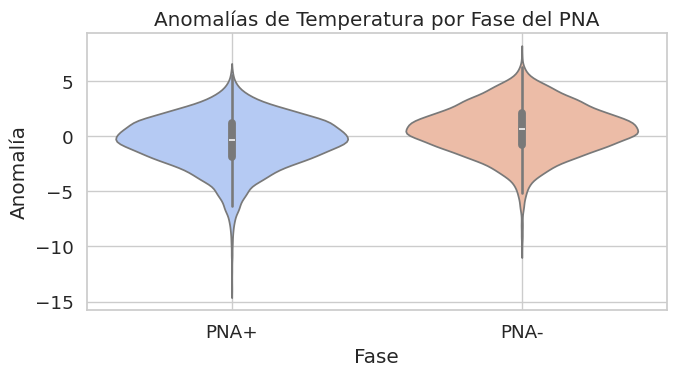

In [301]:
t2m_pos_mean = t2m_ds_idxp.to_series()
t2m_neg_mean = t2m_ds_idxn.to_series()

df = pd.DataFrame({
    "Anomalía": pd.concat([t2m_pos_mean, t2m_neg_mean]),
    "Fase": (
        ["PNA+"] * len(t2m_pos_mean) +
        ["PNA-"] * len(t2m_neg_mean)
    )
})

plt.figure(figsize=(7, 4))
sns.violinplot(data=df, x="Fase", y="Anomalía", palette="coolwarm")
plt.title("Anomalías de Temperatura por Fase del PNA")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


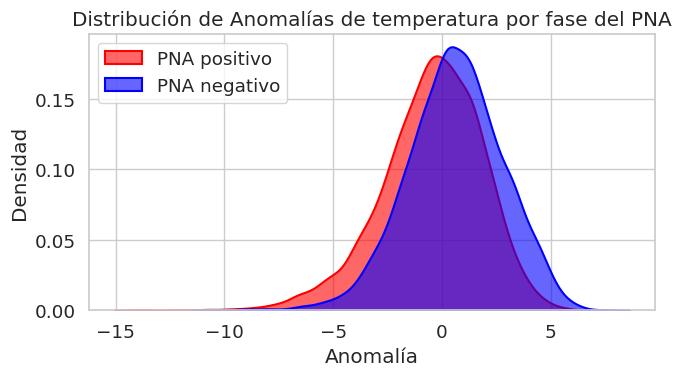

In [302]:
# Separar los datos por fase
pos_data = df[df["Fase"] == "PNA+"]["Anomalía"]
neg_data = df[df["Fase"] == "PNA-"]["Anomalía"]

plt.figure(figsize=(7, 4))
sns.kdeplot(pos_data, label="PNA positivo", color="red", fill=True, linewidth=1.5, alpha=0.6)
sns.kdeplot(neg_data, label="PNA negativo", color="blue", fill=True, linewidth=1.5, alpha=0.6)

plt.title("Distribución de Anomalías de temperatura por fase del PNA")
plt.xlabel("Anomalía")
plt.ylabel("Densidad")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### **<font color="Purple"> Datos de HadGEM3</font>**

### **<font color="olive"> Temperatura </font>**

In [329]:
tas_file = 'datasetsok/tasday79.nc'

In [330]:
#archivo historical
tas_ds=xr.open_dataset(tas_file)
tas=tas_ds['tas']
tas['time'] = tas.time.dt.floor("D")

In [305]:
tas_inviernos = tas.sel(time=tas['time.month'].isin([12, 1, 2]))

##### **<font color="olive"> Promedio de área </font>**

In [331]:
#Elegir un cuadro de 4x4
latitudes = tas.sel(lat=slice(22,27))
longitudes = latitudes.sel(lon=slice(255,262))

In [332]:
weights = np.cos(np.deg2rad(latitudes.lat))
weights.name = "weights"

In [333]:
tas_weighted = longitudes.weighted(weights)

In [334]:
promareaHG = tas_weighted.mean(['lon','lat']) 

In [335]:
#desestacionalizar promedio de área

In [336]:
tas_climday = promareaHG.groupby('time.dayofyear').mean('time') #este es el ciclo anual 

In [337]:
tasclimdaysuav = tas_climday.rolling(dayofyear=7, center=True, min_periods=1).mean()

In [338]:
anomaliasdayHG = promareaHG.groupby('time.dayofyear') - tasclimdaysuav 

##### **<font color="olive"> Geopotencial </font>**

##### **<font color="olive"> Concat de índice >1 y valores de gph </font>**

In [339]:
idxp_zg_file = 'datasetsok/zg500_idx_std+.nc'
idxp_zg_ds = xr.open_dataset(idxp_zg_file)
idxp_zg = idxp_zg_ds['zg500']
idxp_zg['time'] = idxp_zg.time.dt.floor("D")

##### **<font color="olive"> Temperatura e índice >1 (con valores de gph) </font>**

In [340]:
missing_times = np.setdiff1d(idxp_zg.time.values, anomaliasdayHG.time.values)
# print(missing_times)
len(missing_times)

0

##### **<font color="olive"> Concat de índice <-1 y valores de gph </font>**

In [341]:
idxn_zg_file = 'datasetsok/zg500_idx_std-.nc'
idxn_zg_ds = xr.open_dataset(idxn_zg_file)
idxn_zg = idxn_zg_ds['zg500']
idxp_zg['time'] = idxp_zg.time.dt.floor("D")

##### **<font color="olive"> Temperatura e índice <-1 (con valores de gph) </font>**

In [343]:
missing_times = np.setdiff1d(idxp_zg.time.values, anomaliasdayHG.time.values)
# print(missing_times)
len(missing_times)

0

In [346]:
tas_idxp=anomaliasdayHG.sel(time=idxp_zg.time.values)

In [345]:
tas_idxn=anomaliasdayHG.sel(time=idxn_zg.time.values)

In [348]:
tas_pos_mean = tas_idxp.to_series()
tas_neg_mean = tas_idxn.to_series()

dfHG = pd.DataFrame({
    "Anomalía": pd.concat([tas_pos_mean, tas_neg_mean]),
    "Fase": (
        ["PNA positivo"] * len(tas_pos_mean) +
        ["PNA negativo"] * len(tas_neg_mean)
    )
})

/tmp/ipykernel_232/2607725213.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=dfHG, x="Fase", y="Anomalía", palette="coolwarm")


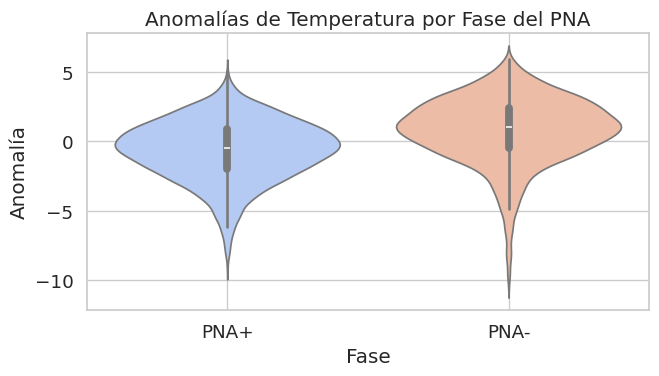

In [358]:
tas_pos_mean = tas_idxp.to_series()
tas_neg_mean = tas_idxn.to_series()

dfHG = pd.DataFrame({
    "Anomalía": pd.concat([tas_pos_mean, tas_neg_mean]),
    "Fase": (
        ["PNA+"] * len(tas_pos_mean) +
        ["PNA-"] * len(tas_neg_mean)
    )
})

plt.figure(figsize=(7, 4))
sns.violinplot(data=dfHG, x="Fase", y="Anomalía", palette="coolwarm")
plt.title("Anomalías de Temperatura por Fase del PNA")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


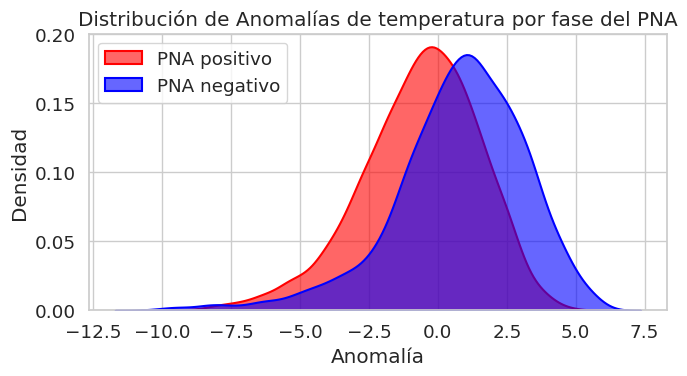

In [359]:
# Separar los datos por fase
pos_data = dfHG[dfHG["Fase"] == "PNA+"]["Anomalía"]
neg_data = dfHG[dfHG["Fase"] == "PNA-"]["Anomalía"]

plt.figure(figsize=(7, 4))
sns.kdeplot(pos_data, label="PNA positivo", color="red", fill=True, linewidth=1.5, alpha=0.6)
sns.kdeplot(neg_data, label="PNA negativo", color="blue", fill=True, linewidth=1.5, alpha=0.6)

plt.title("Distribución de Anomalías de temperatura por fase del PNA")
plt.xlabel("Anomalía")
plt.ylabel("Densidad")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_232/2046072575.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=dfHG, x="Fase", y="Anomalía", palette="coolwarm", ax=axes[0])
/tmp/ipykernel_232/2046072575.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=dfT2M, x="Fase", y="Anomalía", palette="coolwarm", ax=axes[1])


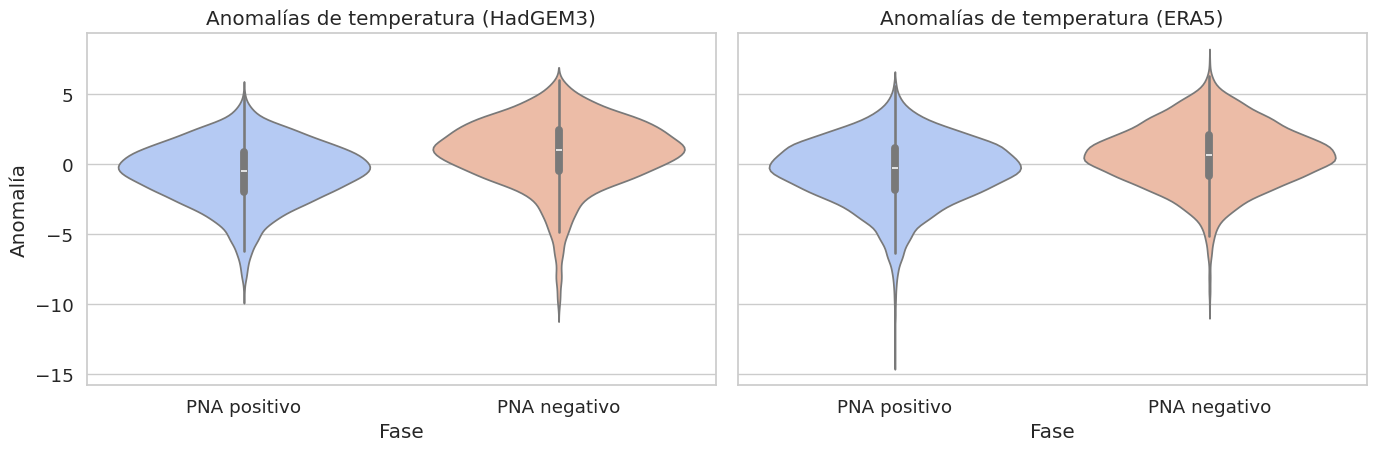

In [355]:
tas_pos_mean = tas_idxp.to_series()
tas_neg_mean = tas_idxn.to_series()

dfHG = pd.DataFrame({
    "Anomalía": pd.concat([tas_pos_mean, tas_neg_mean]),
    "Fase": (
        ["PNA positivo"] * len(tas_pos_mean) +
        ["PNA negativo"] * len(tas_neg_mean)
    )
})


t2m_pos_mean = t2m_ds_idxp.to_series()
t2m_neg_mean = t2m_ds_idxn.to_series()

dfT2M = pd.DataFrame({
    "Anomalía": pd.concat([t2m_pos_mean, t2m_neg_mean]),
    "Fase": (
        ["PNA positivo"] * len(t2m_pos_mean) +
        ["PNA negativo"] * len(t2m_neg_mean)
    )
})

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot 1: tas
sns.violinplot(data=dfHG, x="Fase", y="Anomalía", palette="coolwarm", ax=axes[0])
axes[0].set_title("Anomalías de temperatura (HadGEM3)")
axes[0].grid(True, axis='y')

# Plot 2: t2m
sns.violinplot(data=dfT2M, x="Fase", y="Anomalía", palette="coolwarm", ax=axes[1])
axes[1].set_title("Anomalías de temperatura (ERA5)")
axes[1].grid(True, axis='y')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


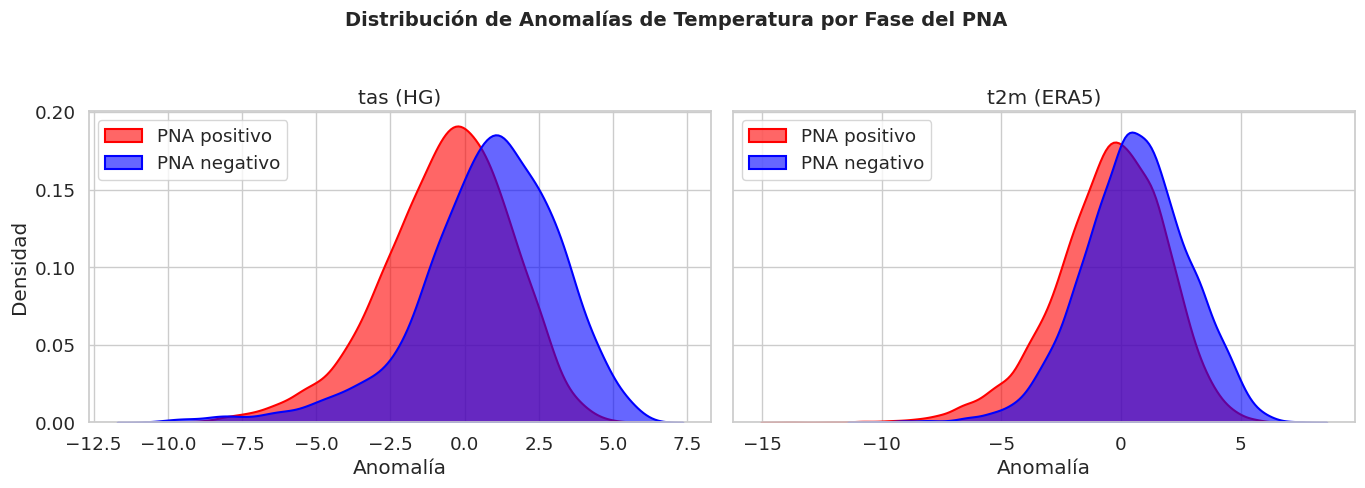

In [360]:
import matplotlib.pyplot as plt
import seaborn as sns

# Separar datos por fase para dfHG (tas)
pos_hg = dfHG[dfHG["Fase"] == "PNA+"]["Anomalía"]
neg_hg = dfHG[dfHG["Fase"] == "PNA-"]["Anomalía"]

# Separar datos por fase para df (t2m)
pos_t2m = df[df["Fase"] == "PNA+"]["Anomalía"]
neg_t2m = df[df["Fase"] == "PNA-"]["Anomalía"]

# Crear figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# KDE plot para tas (HG)
sns.kdeplot(pos_hg, label="PNA positivo", color="red", fill=True, linewidth=1.5, alpha=0.6, ax=axes[0])
sns.kdeplot(neg_hg, label="PNA negativo", color="blue", fill=True, linewidth=1.5, alpha=0.6, ax=axes[0])
axes[0].set_title("tas (HG)")
axes[0].set_xlabel("Anomalía")
axes[0].set_ylabel("Densidad")
axes[0].grid(True)
axes[0].legend()

# KDE plot para t2m
sns.kdeplot(pos_t2m, label="PNA positivo", color="red", fill=True, linewidth=1.5, alpha=0.6, ax=axes[1])
sns.kdeplot(neg_t2m, label="PNA negativo", color="blue", fill=True, linewidth=1.5, alpha=0.6, ax=axes[1])
axes[1].set_title("t2m (ERA5)")
axes[1].set_xlabel("Anomalía")
axes[1].set_ylabel("")
axes[1].grid(True)
axes[1].legend()

# Título general
fig.suptitle("Distribución de Anomalías de Temperatura por Fase del PNA", fontsize=14, weight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
